# U.S. Small Business Administration Loans
Lab Assignment Five: Wide and Deep Networks

*Mark Brubaker*

In [1]:
# this is in a python cell because markdown won't show it properly
'''
Attribute -             Description
State -                 State where the business is located
BankState -             State where the bank is located
NAICSCode -             Code denoting industry
ApprovalFY -            Fiscal year of approval
Term -                  The length of the loan in months
NoEmp -                 The number of employees the business has
NewExist -              Whether the business is new or existing
CreateJob -             The number of jobs the loan will create
RetainedJob -           The number of jobs the loan will retain
FranchiseCode -         The code for the franchise / if in a franchise
UrbanRural -            Whether the business is  urban or rural
RevLineCr -             Whether the business has a revolving line of credit
LowDoc -                If the loan used the low documentation option
DisbursementGross -     The amount of the loan
GrAppv -                The amount of the loan approved by the Bank
SBA_Appv -              The amount of the loan guaranteed by the SBA
'''

# print a link to the data
print("https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied")

https://www.kaggle.com/mirbektoktogaraev/should-this-loan-be-approved-or-denied


In [2]:
import pickle
import time
import pandas as pd
import numpy as np
from sklearn import metrics as mt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {‘0’, ‘1’, ‘2’}
os.environ['AUTOGRAPH_VERBOSITY'] = '0'

import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

# set pandas to display not using scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

LOAD_FROM_PICKLE = True
USE_GPU = True

In [3]:
# The kernel needs to be restarted before changing this setting to take effect

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
# Tensorflow import needs to be after setting the CUDA_VISIBLE_DEVICES

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Activation, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import concatenate
from tensorflow.python.keras import backend as K
from keras.utils.vis_utils import plot_model

# print Tensorflow and CUDA information
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")


Num GPUs Available:  1
Num CPUs Available:  1
Tensorflow version: 2.10.1
Keras version: 2.10.0
GPU found


In [5]:
if LOAD_FROM_PICKLE:
    with open('../Data/Pickle/loans.pickle', 'rb') as handle:
        df = pickle.load(handle)

    print('Loaded data from pickle')
else:
    # df = pd.read_csv('../Data/Loans/SBAnational.csv', low_memory=False, nrows=100000)
    df = pd.read_csv('../Data/Loans/SBAnational.csv', low_memory=False)

    # drop duplicate rows
    df.drop_duplicates(keep='first', inplace=True)

    # drop rows where BalenceGross is not 0
    # this means that the loan has neither been paid off nor defaulted
    df = df[df['BalanceGross'].str.strip() == '$0.00']

    # drop rows where NAICSCode is 0
    # there are enough missing values in this column that it cannot be reliably imputed
    df = df[df['NAICS'] != 0]

    # divide remaining NAICS codes by 100 to get the first two digits
    # the first two digits of the NAICS code are the industry code
    df['NAICS'] = df['NAICS'].astype(int) // 10000

    # drop rows where NewExist is 0 then
    # subtract 1 from NewExist to make it 0-based
    df = df[df['NewExist'] != 0]
    df['NewExist'] = df['NewExist'] - 1

    # drop columns that are not needed
    df = df.drop(['Bank', 'LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'DisbursementDate', 'ChgOffDate', 'BalanceGross', 'ChgOffPrinGr'], axis=1)

    # convert Yes/No and PIF/CHGOFF to 1/0 integers
    # floats is temporary, will be converted to ints later after imputing missing values
    df['RevLineCr'] = df['RevLineCr'].map({'Y': 1, 'N': 0, '1' : 1, '0' : 0})
    df['LowDoc'] = df['LowDoc'].map({'Y': 1, 'N': 0})
    df['MIS_Status'] = df['MIS_Status'].map({'P I F': 1, 'CHGOFF': 0})

    # remove rows with missing MIS_Status
    # this is the target variable and shouldnt be imputed   
    df = df[df['MIS_Status'].notnull()]
    
    # rename MIS_Status to paid_off
    df = df.rename(columns={'MIS_Status': 'Paid_In_Full'})

    # for franchiseCode set all values over 1 to 1
    # the value is not important, only if it is a franchise or not
    df['FranchiseCode'] = df['FranchiseCode'].astype(int)
    df['FranchiseCode'] = df['FranchiseCode'].apply(lambda x: 1 if x > 1 else 0)

    # convert dollar amounts to floats
    df['DisbursementGross'] = df['DisbursementGross'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['GrAppv'] = df['GrAppv'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['SBA_Appv'] = df['SBA_Appv'].str.replace('$', '').str.replace(',', '').str.replace('\.00', '').astype(float)
    df['ApprovalFY'] = df['ApprovalFY'].astype(int)

    for col in ['City', 'State', 'BankState']:
        df[col] = df[col].str.strip()
        df[col] = df[col].str.upper()

    num_rows = df.shape[0]
    # drop rows with missing values
    # this is about 3% of the data
    df = df.dropna()

    dropped_rows = num_rows - df.shape[0]
    dropped_percent = dropped_rows / num_rows * 100
    print('Dropped {} rows with missing values'.format(dropped_rows))
    print('Dropped {:.2f}% of the data'.format(dropped_percent))

    # convert NewExist, RevLineCr, and LowDoc to int
    df['NewExist'] = df['NewExist'].astype('int')
    df['RevLineCr'] = df['RevLineCr'].astype('int')
    df['LowDoc'] = df['LowDoc'].astype('int')

    # create a new column for if the buisness state is the same as the bank state
    # in the first lab I discovered this had a significant impact on if the loan was paid off or not
    df['BankStateSame'] = df['State'].eq(df['BankState']).astype(int)

    # create a new column for if the term of the loan is a standard amount ie. 5, 7, or 10 years
    # standart term loans are more likely to be paid off
    # map to '5_years', '7_years', '10_years', 'other'
    def term_map(term):
        if term == 60:
            return '5_years'
        elif term == 84:
            return '7_years'
        elif term == 120:
            return '10_years'
        else:
            return 'other'
    df['StdTerm'] = df['Term'].apply(term_map)

    # save data to pickle
    with open('../Data/Pickle/loans.pickle', 'wb') as handle:
        pd.to_pickle(df, handle, protocol=4)

Loaded data from pickle


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672172 entries, 0 to 899161
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               672172 non-null  object 
 1   State              672172 non-null  object 
 2   Zip                672172 non-null  int64  
 3   BankState          672172 non-null  object 
 4   NAICS              672172 non-null  int64  
 5   ApprovalFY         672172 non-null  int64  
 6   Term               672172 non-null  int64  
 7   NoEmp              672172 non-null  int64  
 8   NewExist           672172 non-null  int64  
 9   CreateJob          672172 non-null  int64  
 10  RetainedJob        672172 non-null  int64  
 11  FranchiseCode      672172 non-null  int64  
 12  UrbanRural         672172 non-null  int64  
 13  RevLineCr          672172 non-null  int64  
 14  LowDoc             672172 non-null  int64  
 15  DisbursementGross  672172 non-null  float64
 16  Pa

In [7]:
numeric_headers = ['ApprovalFY', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'GrAppv', 'SBA_Appv']
categorical_headers = ['City', 'State', 'Zip', 'BankState', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'BankStateSame', 'StdTerm']
cross_columns = [
                 ['State', 'BankState'],
                 ['State', 'UrbanRural'],
                 ['NAICS', 'NewExist', 'UrbanRural'],
                 ['RevLineCr', 'StdTerm']
                ]

Above, the set of numeric and categorical are listed. Each of the crossed feartures are also listed.

I have already created a sepreate column for loans where the state the buisness is loacated in is different from the state the bank is based in (i.e. the bank is not local) because I previously found this to be a significant factor in default rates. Further exploring this idea I have crossed 'Bank' and 'BankState' to let the model decide if this should hold true for all pairs of states or just some.

Next I crossed 'State' and 'UrbanRural' as I felt like this would further divide each state into more precisce groups. The culture in a state can vary greatly between rural and urban areas and it may also have an effect on the default rate.

I also crossed 'NAICS', 'NewExisting', and 'UrbanRural' in order to group types of companies that may be related together. Companies in the same industry may have different default rates depending on if they are new or existing and if they are in a rural or urban area.

Finally I crossed if there is a revolving line of credit with if the loan is for a standerd term length as both ar factors of if the buisness has a plan to pay back the loan.

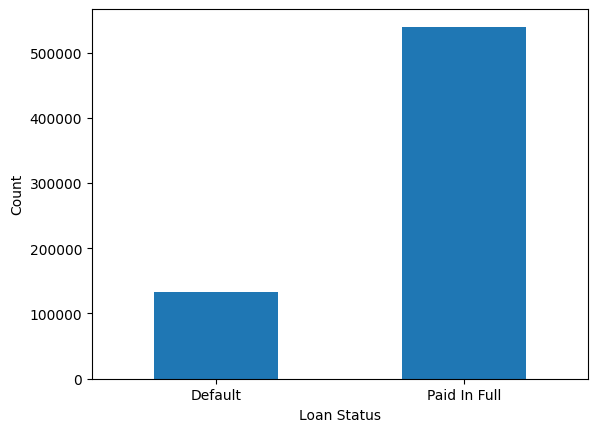

In [8]:
df.groupby('Paid_In_Full').size().plot(kind='bar')
plt.xticks([0, 1], ['Default', 'Paid In Full'], rotation=0)
plt.ylabel('Count')
plt.xlabel('Loan Status')
plt.show()

A clear use case for this model is predicting if a SBA loan will default or not. A bank could use the prediction to decide if potential loans should be given to a business. In this use case, the best metric is the f1 score beacuse both precision and recall are important. Precision can be interpreted as the ratio of busisnesses the will actually pay off their loans to the total number of loans given out. This is the percentage of loans that end up being profitable. Recall can be interpreted as the ratio of businesses that recive loans and pay them off to the total number of buisnesses that would have paid off their loans if they had been given one. This is the share of the market captured by the bank. The priority between these two metrics may not be an even mix because of the nature of the loans. A large portion of SBA loans are guarnteed by the goverment which caps the amount of money that can be lost. This would also need to be factored in with the intreset rate to determine how much a bank would stand to make from a loan. How much risk a bank is willing to take on would be the final piece of the puzzle to determine the best metric for this use case. Because there is missing information I will be using the standard f1 score.

In [9]:
# ideally encoding would be done after splitting the data into train and test sets
# but because of the number of unique values in some of the categorical features
# which only increases after incluing crossed features this cannot be done. This will
# lead to a small amount of data snooping. This will also lead to some values of features like
# city and zip appearing in the test set that were not in the training set leading to the model making
# uninformed decisions from thoes inputs 

# encode categorical features
categorical_num_unique = {}
categorical_headers_encoded = []

for col in categorical_headers:
    enc = LabelEncoder()

    # fit the encoder to the data
    enc.fit(df[col])

    # save for later use
    unique_values = len(enc.classes_)

    # if the feature is binary then skip
    if unique_values == 2:
        categorical_headers_encoded.append(col)
        categorical_num_unique[col] = unique_values
        continue
    else:
        # fit the encoder to the data and save the mapping in a new column
        df[col + '_encoded'] = enc.fit_transform(df[col])
        categorical_headers_encoded.append(col + '_encoded')  
        categorical_num_unique[col + '_encoded'] = unique_values  

print(f'Encoded {len(categorical_headers)} categorical features')
print(f'{categorical_headers}\n')

# cross each set of columns in the list cross_columns list and encode
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()
    
    # 1. create crossed labels converting to strings and joining with '_'
    crossed = df[cols_list].astype(str).apply('_'.join, axis=1)
    
    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)
    
    # 2. encode as integers
    enc.fit(crossed)
    
    # 3. Save into dataframe with new name
    df[cross_col_name] = enc.transform(crossed)
    
    # Save the number of unique values for each column for later use
    categorical_num_unique[cross_col_name] = len(enc.classes_)
    
    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)
    
print(f'Encoded {len(cross_col_df_names)} crossed columns')
print(f'{cross_col_df_names}\n')

print(f'Numbe of unique values in each categorical feature')
print(categorical_num_unique)


Encoded 12 categorical features
['City', 'State', 'Zip', 'BankState', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'BankStateSame', 'StdTerm']

Encoded 4 crossed columns
['State_BankState', 'State_UrbanRural', 'NAICS_NewExist_UrbanRural', 'RevLineCr_StdTerm']

Numbe of unique values in each categorical feature
{'City_encoded': 21036, 'State_encoded': 51, 'Zip_encoded': 30351, 'BankState_encoded': 55, 'NAICS_encoded': 24, 'NewExist': 2, 'FranchiseCode': 2, 'UrbanRural_encoded': 3, 'RevLineCr': 2, 'LowDoc': 2, 'BankStateSame': 2, 'StdTerm_encoded': 4, 'State_BankState': 1613, 'State_UrbanRural': 153, 'NAICS_NewExist_UrbanRural': 144, 'RevLineCr_StdTerm': 8}


In [10]:
# seperate the target variable from the rest of the data
X = df.drop(['Paid_In_Full'], axis=1)
y = df['Paid_In_Full']

# test train split stratified by the target variable
df_train, df_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, stratify=y)

I believe a 80/20 split is a good choice for this dataset. The main argument for this is its large size with 672172 enteries. At this size the target vaiable (if the loan was paid off) is well represented in both the training and test set. This will mirror how the model woul be used in the real word. A bank would have lots of past data on how most of the features effect the traget, but it is very reasonable that they may get a request for a loan from a city or zip code they have not lent to before. In order to avoid the issue described above when the final model is fed an encoding of a brand new city or zip code, a different feature could be used where a new value still conveyed some usefull information. As it stands, the final model will put a new value into an encoding layer that was not trained to expect it. If instead city and zip were replaced by a metric about that location like average income then a new value would still be usefull to the model. This would have to be done cautiously, as a metric like the income of an area may be highly influenced by charicteristics like racial makeup and based in centries of racism whos influence would want to be removed from the model. Race should not be used as a factor when deciding if a loan application should be accepted.

In [11]:
# scale the numeric features
ss = StandardScaler()
df_train[numeric_headers] = ss.fit_transform(df_train[numeric_headers].values)
df_test[numeric_headers] = ss.transform(df_test[numeric_headers].values)

# convert target to numpy arrays
y_train = y_train.values.astype(np.int32)
y_test = y_test.values.astype(np.int32)

The numeric values in the test set are scaled based on thoes found in the training set in order to avoid data snooping

In [27]:
# these three functions are from https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

@tf.autograph.experimental.do_not_convert
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_history(history, name):
    # plot f1 score, loss, and accuracy for training and validation together
    plt.figure(figsize=(20, 5))

    plt.subplot(1,3,1)
    plt.plot(history.history['f1_m'])
    plt.plot(history.history['val_f1_m'])
    plt.ylabel('F1-Score')
    plt.xlabel('epochs')
    plt.title('F1-Score')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,3,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.title('Loss')
    plt.legend(['Train', 'Test'], loc='best')

    plt.subplot(1,3,3)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')
    plt.title('Accuracy')
    plt.legend(['Train', 'Test'], loc='best')

    # set the title for the whole figure
    plt.suptitle(name, fontsize=16)

    plt.show()

def plot_ROC_curve(y_test, yhat, model_names):
    plt.figure(figsize=(10, 10))

    # plot the curve for each pair of y_test and yhat on the same plot
    for y_guess, name in zip(yhat, model_names):
        fpr, tpr, _ = mt.roc_curve(y_test, y_guess)
        auc = mt.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=name + ' (area = %0.3f)' % auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


Theses are some helper functions for recording metrics, plotting model performance, and plotting the ROC curve.

In [13]:
# prepare the input data
# this is the same for all models

# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()

# save categorical features
X_train_cat = df_train[categorical_headers_encoded].to_numpy() 
X_test_cat = df_test[categorical_headers_encoded].to_numpy() 

# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num = df_test[numeric_headers].to_numpy()

def generate_input_layers():
    # we need to create separate lists for each branch
    crossed_outputs = []

    # CROSSED DATA INPUT
    input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
    for idx, col in enumerate(cross_col_df_names):
        
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = categorical_num_unique[col]
        N_reduced = int(np.sqrt(N))
        
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_crossed, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        crossed_outputs.append(x)
        

    # now concatenate the outputs and add a fully connected layer
    wide_branch = concatenate(crossed_outputs, name='wide_concat')

    # reset this input branch
    all_deep_branch_outputs = []

    # CATEGORICAL DATA INPUT
    input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
    for idx,col in enumerate(categorical_headers_encoded):
        
        # track what the maximum integer value will be for this variable
        # which is the same as the number of categories
        N = categorical_num_unique[col]
        N_reduced = int(np.sqrt(N))
        
        # this line of code does this: input_branch[:,idx]
        x = tf.gather(input_cat, idx, axis=1)
        
        # now use an embedding to deal with integers as if they were one hot encoded
        x = Embedding(input_dim=N, 
                    output_dim=N_reduced, 
                    input_length=1, name=col+'_embed')(x)
        
        # save these outputs to concatenate later
        all_deep_branch_outputs.append(x)
        
    # NUMERIC DATA INPUT
    # create dense input branch for numeric
    input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
    x_dense = Dense(units=20, activation='relu',name='num_1')(input_num)
        
    all_deep_branch_outputs.append(x_dense)

    return input_crossed, input_cat, input_num, all_deep_branch_outputs, wide_branch

The initial layers are the same for every model run.

In [14]:
def generate_final_layers(input_crossed, input_cat, input_num, all_deep_branch_outputs, wide_branch, deep_layer_sizes, name):
    # now concatenate the outputs and add a fully connected layer
    deep_branch = concatenate(all_deep_branch_outputs, name='deep_concat')
    for idx, layer_size in enumerate(deep_layer_sizes):
        deep_branch = Dense(units=layer_size, activation='relu',name='deep_'+str(idx))(deep_branch)

    # now concatenate the two branches
    # merge the deep and wide branch
    final_branch = concatenate([wide_branch, deep_branch],
                            name='concat_deep_wide')
    final_branch = Dense(units=1,activation='sigmoid',
                        name='combined')(final_branch)

    model = Model(   inputs=[input_crossed, input_cat, input_num], 
                                outputs=final_branch,
                                name=name)
                            
    return model

This generates the remaining layers for the model.

In [15]:
deep_layer_sizes = [[128, 64, 32], [256, 128, 64, 32], [256, 256, 128, 64, 32]]
model_names = ['wide_deep3', 'wide_deep4', 'wide_deep5']

# create a list to store the models
models = []

for layer_sizes, name in zip(deep_layer_sizes, model_names):
    input_crossed, input_cat, input_num, all_deep_branch_outputs, wide_branch = generate_input_layers()
    model = generate_final_layers(input_crossed, input_cat, input_num, all_deep_branch_outputs, wide_branch, layer_sizes, name)
    models.append(model)

Creates a wide and deep model with 3 deep layers

Create a wide and deep model with 4 deep layers. The extra layer is added to the front of the deep layers and has twice the number of nodes as the previous first layer.

Create a wide and deep model with 5 deep layers. The extra layer is added to the front of the deep layers and has the same number of nodes as the previous first layer.

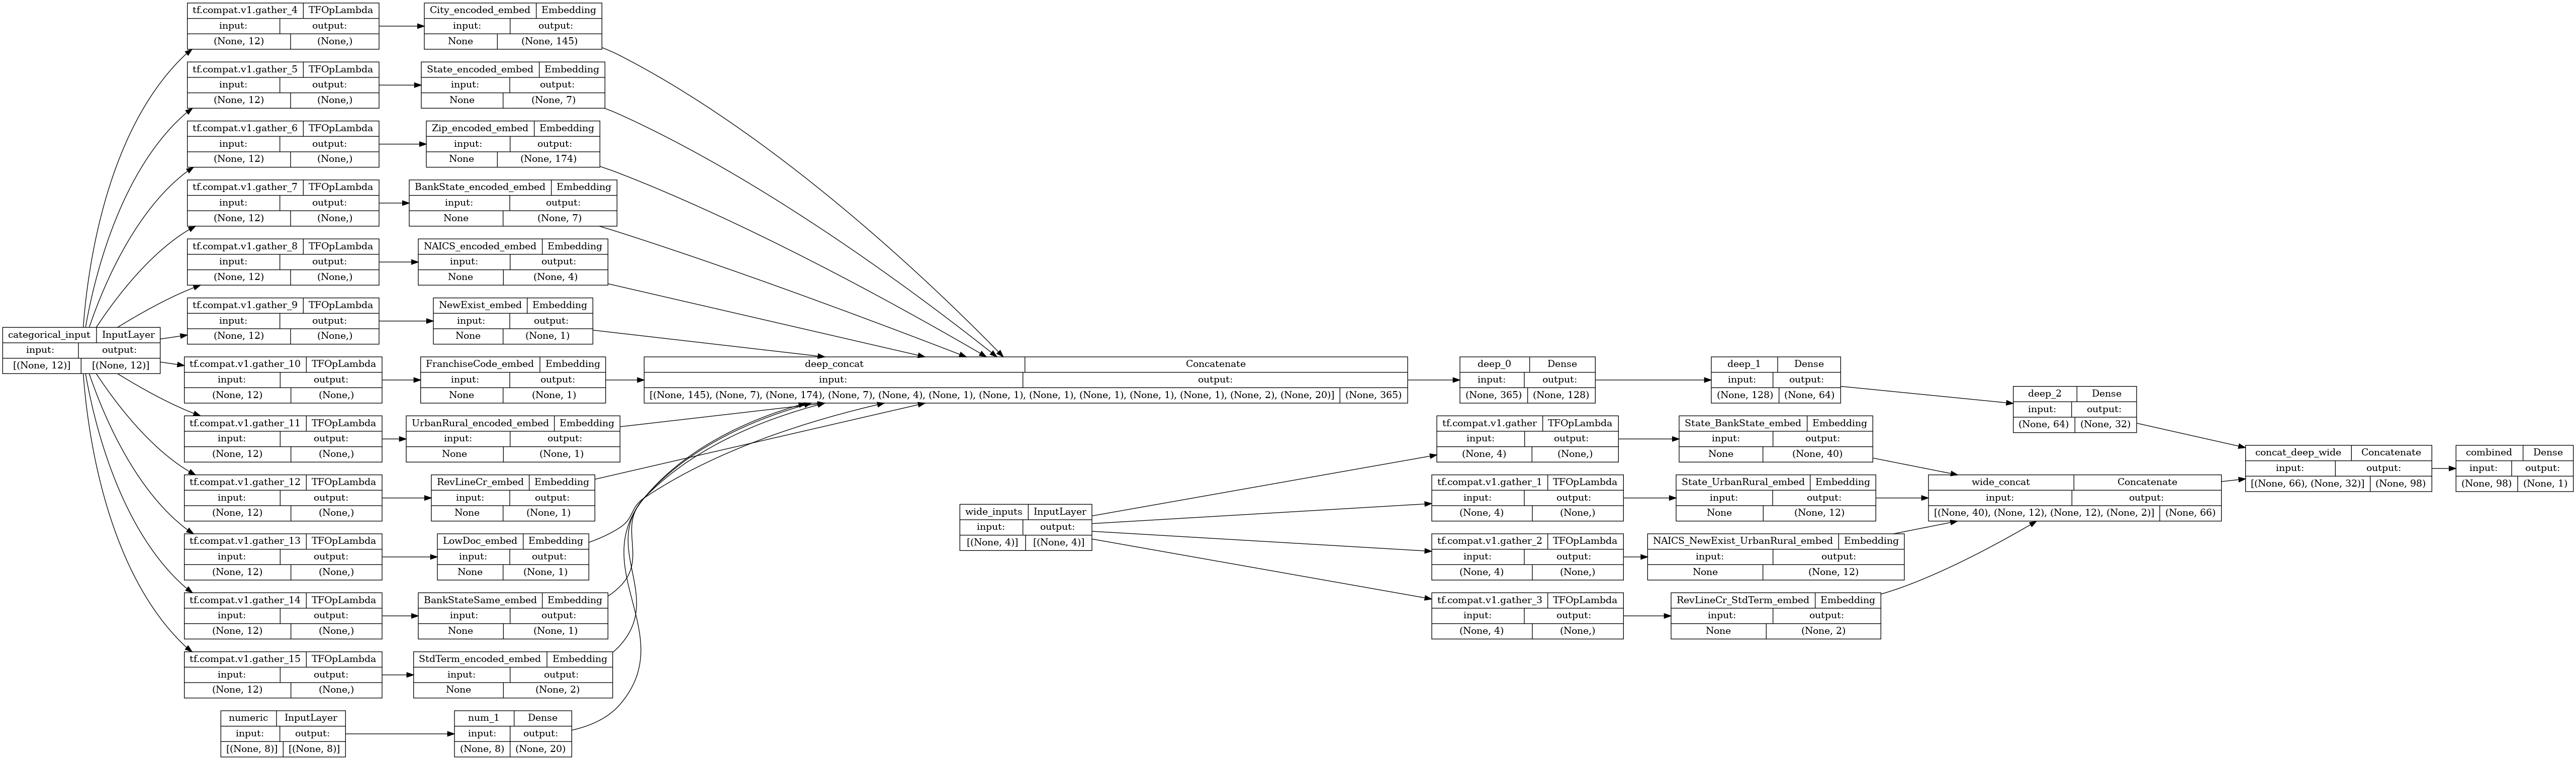

In [16]:
plot_model(
    models[0], to_file=f'Images/{model_names[0]}.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

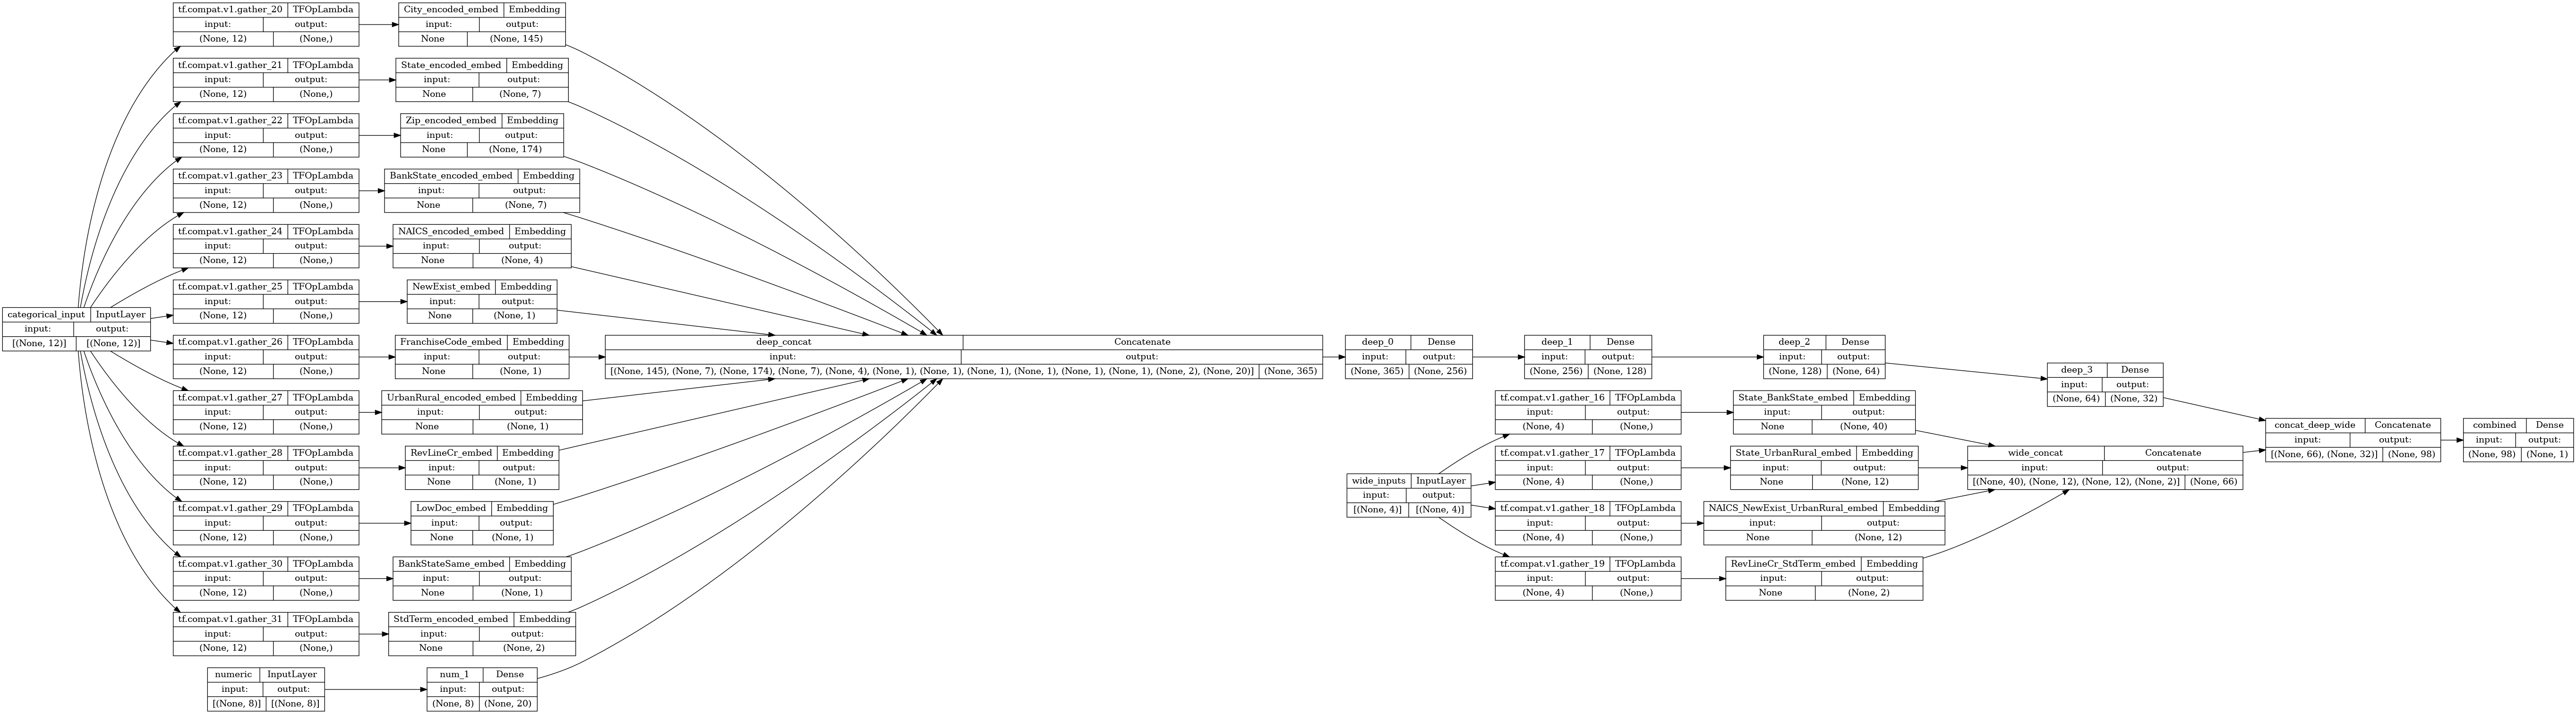

In [17]:
plot_model(
    models[1], to_file=f'Images/{model_names[1]}.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

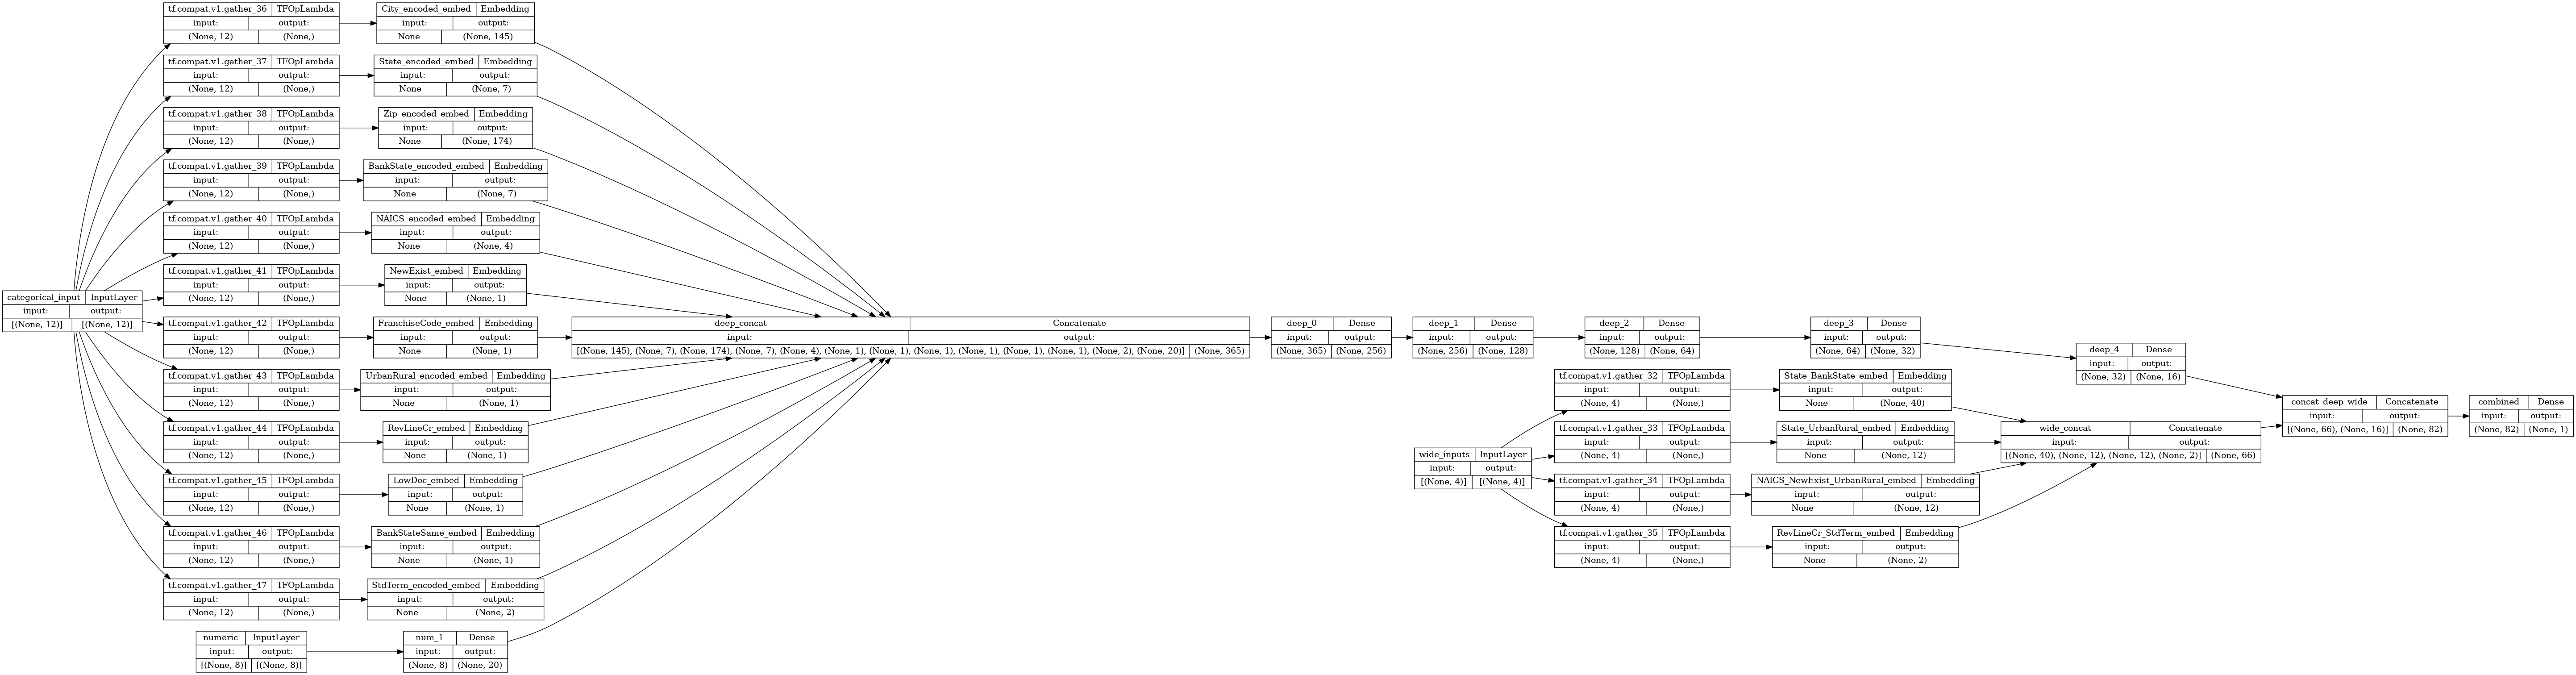

In [18]:
plot_model(
    models[2], to_file=f'Images/{model_names[2]}.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [19]:
params = {
    'x': [X_train_crossed,X_train_cat,X_train_num],
    'y': y_train,
    'epochs': 40,
    'batch_size': 8192,
    'verbose': 0,
    'validation_data': ([X_test_crossed,X_test_cat,X_test_num], y_test)
}

histories = []

for model in models:
    # use accuracy and f1 score as metrics to compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m])

    print(f'Model {model.name} has {model.count_params():,} parameters')

    # fit the model and store the history
    start_time = time.time()
    history = model.fit(**params)
    print(f'Model {model.name} took {round(time.time() - start_time, 2)} seconds to train\n')

    # store the history
    histories.append(history)

Model wide_deep3 has 8,457,716 parameters
Model wide_deep3 took 62.61 seconds to train

Model wide_deep4 has 8,537,460 parameters
Model wide_deep4 took 63.6 seconds to train

Model wide_deep5 has 8,537,972 parameters
Model wide_deep5 took 71.05 seconds to train



Here all the models are trained and the results are recorded. It's worth noting that for all three models over 8,200,000 of the parameters are inside of the encoding layers for city and zip due to the large number of unique values in those columns. This means only a few hundred thousand parameters are used for the rest of the model.

In [20]:
# evaluate the models
yhat = []
yhat_rounded = []

for model in models:
    yhat.append(model.predict([X_test_crossed, X_test_cat, X_test_num]))
    yhat_rounded.append(np.round(yhat[-1]))
    print(f'Confusion matrix for {model.name}:')
    print(mt.confusion_matrix(y_test, yhat_rounded[-1]))
    print(f'Classification report for {model.name}:')
    print(mt.classification_report(y_test, yhat_rounded[-1]))
    print()


Confusion matrix for wide_deep3:
[[ 20205   6312]
 [  6541 101377]]
Classification report for wide_deep3:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     26517
           1       0.94      0.94      0.94    107918

    accuracy                           0.90    134435
   macro avg       0.85      0.85      0.85    134435
weighted avg       0.90      0.90      0.90    134435


Confusion matrix for wide_deep4:
[[ 19928   6589]
 [  5552 102366]]
Classification report for wide_deep4:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     26517
           1       0.94      0.95      0.94    107918

    accuracy                           0.91    134435
   macro avg       0.86      0.85      0.86    134435
weighted avg       0.91      0.91      0.91    134435


Confusion matrix for wide_deep5:
[[ 19995   6522]
 [  5733 102185]]
Classification report for wide_deep5:
              precision   

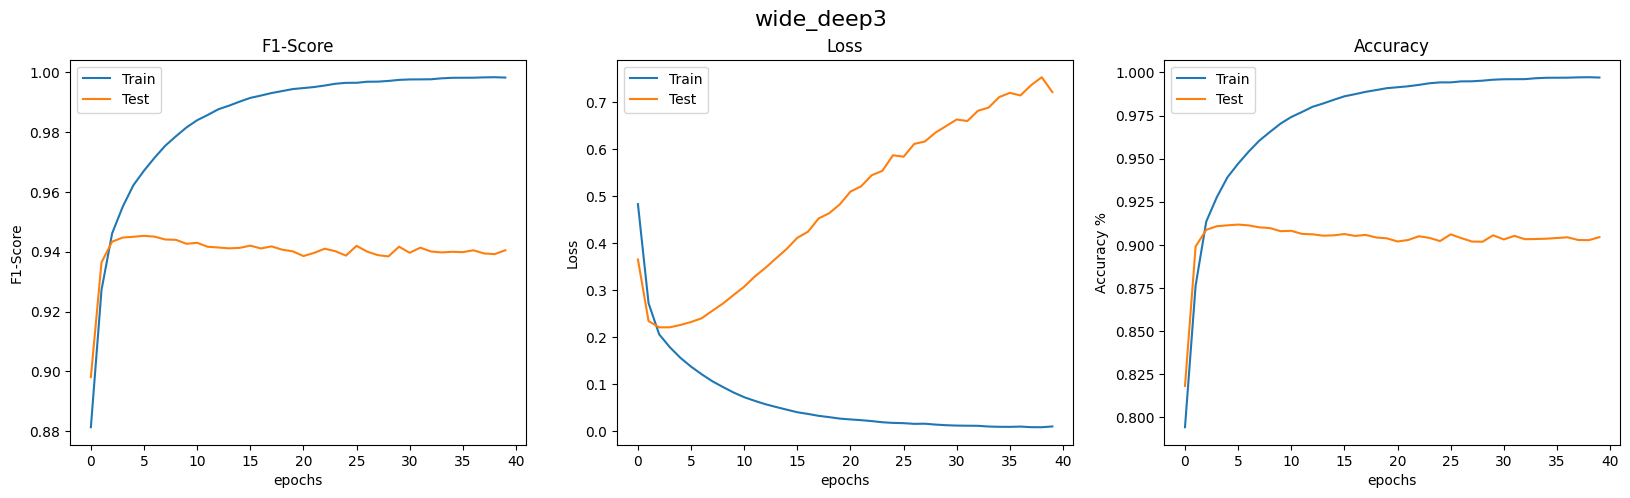

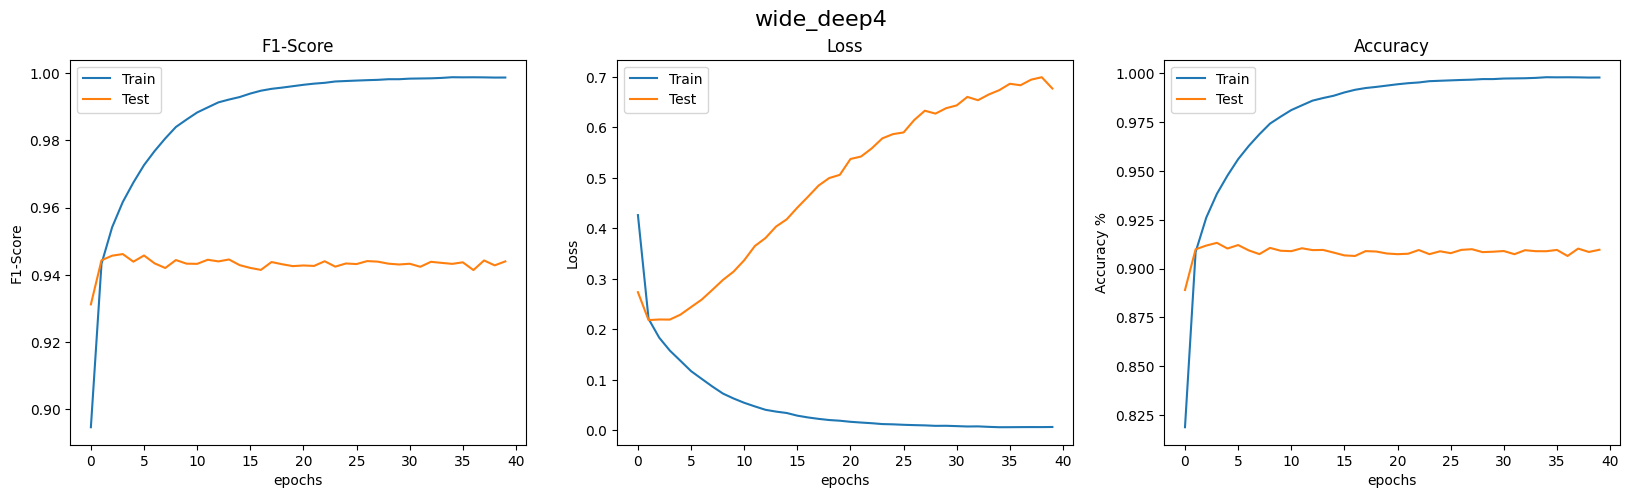

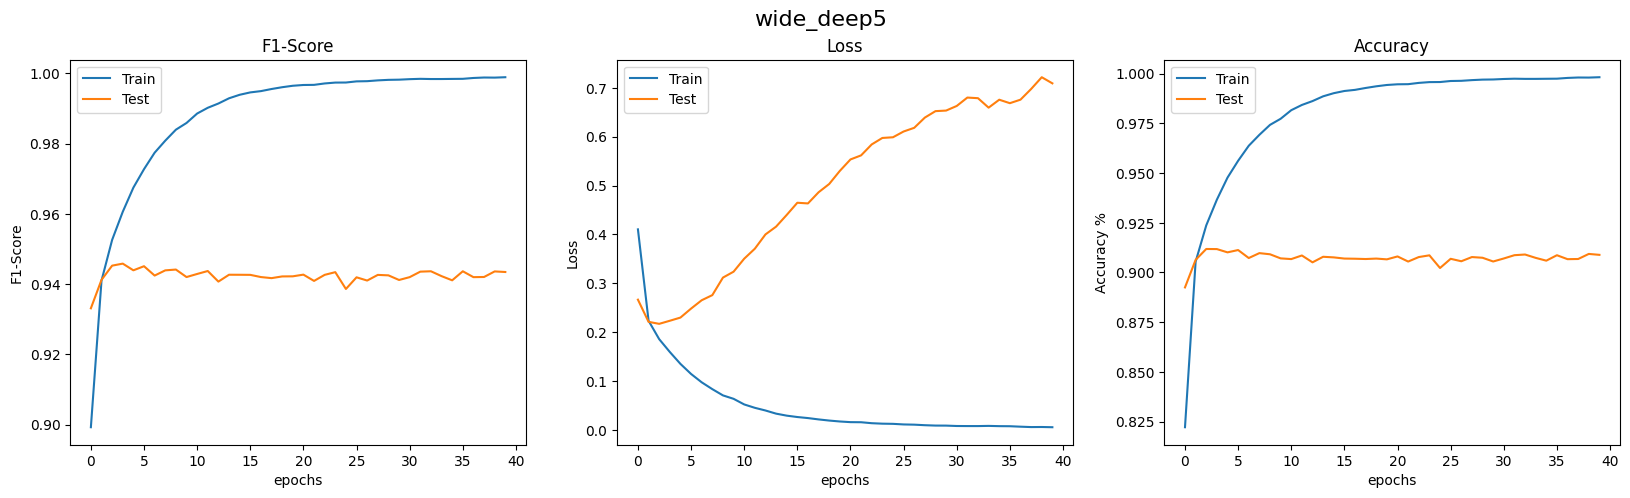

In [21]:
# plot the history of the models
for history, name in zip(histories, model_names):
    plot_history(history, name)

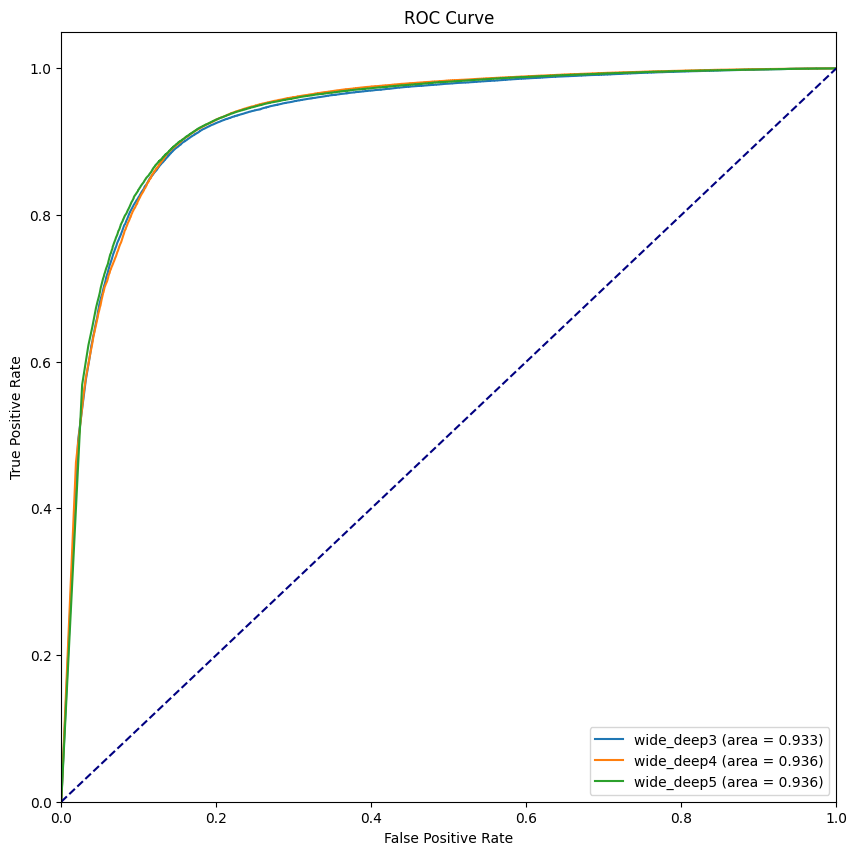

In [28]:
# plot the ROC curves
plot_ROC_curve(y_test, yhat, model_names)